# GAIT RECOGNITION

## 1. Data preparation

Let's create some directories


Download and unzip the CASIA-B dataset.
**********************
IMPORTANT!!!

Replace these cells. The images have to be in the `CASIA/DatasetB/silhouettes/` directory
**********************


In [2]:
# The following code will let us get our dataset in raw format, so it will be necessary to preprocess it (croping and normalization)
%%capture
!git clone https://github.com/chentinghao/download_google_drive.git
!python ./download_google_drive/download_gdrive.py 1Lx1Ltc7UiDjTDXjMjW9tFdgwtR64dhuh GaitDatasetB-silh.zip
!unzip GaitDatasetB-silh.zip
print('Data Extracted')

In [3]:
!unzip CASIA/DatasetB/silhouettes/GaitDatasetB-silh.zip -d CASIA/DatasetB/silhouettes/

unzip:  cannot find or open CASIA/DatasetB/silhouettes/GaitDatasetB-silh.zip, CASIA/DatasetB/silhouettes/GaitDatasetB-silh.zip.zip or CASIA/DatasetB/silhouettes/GaitDatasetB-silh.zip.ZIP.


# ! unzip GaitDatasetB-silh.zip
!mkdir CASIA/
!mkdir CASIA/DatasetB
!mkdir CASIA/DatasetB/silhouettes
!mkdir GEI GEnI data_100_100
!mkdir CASIA/sil

In [1]:
import tarfile
from glob import glob
import shutil
import os

In [2]:
def create_dir(folder, force=True, verbose=False):
    '''   Create a directory if it doesn't exist  '''
    try:
        os.makedirs(folder)
        if verbose: print('Directory {} created succesfully.'.format(folder))   
    except:
        if force:
            if verbose: print('{} already exists. Creating a new one'.format(folder))
            shutil.rmtree(folder)
            os.makedirs(folder)
        else:
            if verbose: print('{} already exists.'.format(folder))
            pass

In [3]:
partA = 'DatasetB-1/silhouettes/'
partB = 'DatasetB-2/silhouettes/'
silhouettes_dir = 'silhouettes/'
# define the path of CASIA directory
CASIA_dir = '/home/israel/Downloads/CASIA/'

In [4]:
from glob import glob
for i in range(50, 125):
    part = partA if i<63 else partB
    if(i%10 == 0):
        print('Extracting Subject:'+str(i).zfill(3)+ '...')
    tf = tarfile.open(os.path.join(CASIA_dir, part, f'{str(i).zfill(3)}.tar.gz'))
    tf.extractall(os.path.join(CASIA_dir, silhouettes_dir))

Extracting Subject:050...
Extracting Subject:060...
Extracting Subject:070...
Extracting Subject:080...
Extracting Subject:090...
Extracting Subject:100...
Extracting Subject:110...
Extracting Subject:120...


## 2. FEATURE NORMALIZATION

In [5]:
import numpy as np
from os import listdir
import cv2
import os
from glob import glob
import time
import matplotlib.pyplot as plt

Let's define some functions to process the contours

In [6]:
def find_if_close(cnt1,cnt2):
    row1,row2 = cnt1.shape[0],cnt2.shape[0]
    for i in range(row1):
        for j in range(row2):
            dist = np.linalg.norm(cnt1[i]-cnt2[j])
            if abs(dist) < 40 :
                return True
            elif i==row1-1 and j==row2-1:
                return False


def joincontours(contours,thresh):
    LENGTH = len(contours)
    status = np.zeros((LENGTH,1))

    for i,cnt1 in enumerate(contours):
        x = i    
        if i != LENGTH-1:
            for j,cnt2 in enumerate(contours[i+1:]):
                x = x+1
                dist = find_if_close(cnt1,cnt2)
                if dist == True:
                    val = min(status[i],status[x])
                    status[x] = status[i] = val
                else:
                    if status[x]==status[i]:
                        status[x] = i+1

    unified = []
    maximum = int(status.max())+1
    for i in range(maximum):
        pos = np.where(status==i)[0]
        if pos.size != 0:
            cont = np.vstack(contours[i] for i in pos)
            hull = cv2.convexHull(cont)
            unified.append(hull)

    cv2.drawContours(thresh,unified,-1,255,-1)
    return thresh

In [7]:
from IPython.display import clear_output
import numpy as np
import cv2
import os
from os import listdir
from glob import glob
import time
import matplotlib.pyplot as plt


def GEI_generator(sil_file, size = 64,debug = False):
  lfiles = os.listdir(sil_file)
  lfiles.sort()
  stack_GEI = []
  if debug:
    plt.figure(figsize=(20,int(len(lfiles)/10)))
  for idimg, path in enumerate(lfiles):
    if debug: plt.subplot((len(lfiles)/15)+1,15, idimg+1)
    img = cv2.imread(sil_file+path,0)
    # Silhouette extraction
    contours1,_ = cv2.findContours(img.copy(),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(img,contours1,-1,255,-1)

    if (len(contours1)>0):
      ncoun= np.concatenate(contours1)[:,0,:]
      x1, y1 = np.min(ncoun,axis=0)
      x2, y2 = np.max(ncoun,axis=0)
      silhouette = img[y1:y2,x1:x2]

      # Normalizae silhouette
      factor = size/max(silhouette.shape)
      height = round(factor*silhouette.shape[0])
      width = round(factor*silhouette.shape[1])
      if(height>width):
        nor_sil = cv2.resize(silhouette,(width,height))
#         print(nor_sil.shape)
        # We add a background of the shape size x size
        portion_body = 0.3                                                      # We take the upper part of the body to center the image and avoid the legs
        moments = cv2.moments(nor_sil[0:int(nor_sil.shape[0]*portion_body),])
        w = round(moments['m10']/moments['m00'])
        background = np.zeros((size, size))
        shift = round((size/2)-w)
#         print('center:',w,' shift:',shift)
        if(shift<0 or shift+nor_sil.shape[1]>size): shift = round((size-nor_sil.shape[1])/2)
        background[:,shift:nor_sil.shape[1]+shift] = nor_sil

        stack_GEI.append(background)
        if debug:
          plt.xticks([])
          plt.yticks([])
          plt.imshow(background,'gray')
          # plt.subplots_adjust(wspace=0.05, hspace=0.01)
  if stack_GEI == []:
    GEI = np.zeros((size, size))
    print('\tNo Files Found')
  else: 
    GEI = np.mean(np.array(stack_GEI),axis=0)
    
  return GEI, stack_GEI

In [54]:
GEI, stack = GEI_generator(rep_sil)

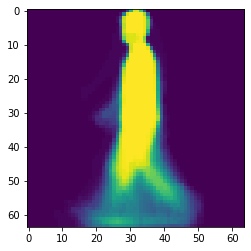

In [55]:
plt.imshow(GEI)

In [8]:
representation_dir = 'representations/'
conditions = np.array(['bg-01','bg-02','cl-01','cl-02','nm-01','nm-02','nm-03','nm-04','nm-05','nm-06'])
view = '090/'
size = 100

subjects = sorted(os.listdir(os.path.join(CASIA_dir, silhouettes_dir)))
count = 0
for subject in subjects:
    print('Sujeto :', subject)
    for condition in conditions:
#     directory_sub = os.path.join(CASIA_dir, representation_dir, subject);
#     if not os.path.exists(directory_sub):
#         os.makedirs(directory_sub)
#     for condition in conditions:
#     directory_condition = os.path.join(CASIA_dir, representation_dir, subject, condition)
#     if not os.path.exists(directory_condition):
#     os.makedirs(directory_condition)

        path = os.path.join(CASIA_dir, silhouettes_dir, subject, condition, view)
        save_path = os.path.join(CASIA_dir, 'GEI/', f'{subject}_{condition}_{view[:-1]}.png')
        GEI, _ = GEI_generator(path, size)
        GEI[int(size*0.12):int(size*0.68),:] = 0
        cv2.imwrite(save_path, GEI)

        if cv2.waitKey(1) & 0xff==27:
            break

cv2.destroyAllWindows()

Sujeto : 001
Sujeto : 002
Sujeto : 003
Sujeto : 004
Sujeto : 005
Sujeto : 006
Sujeto : 007
Sujeto : 008
Sujeto : 009
Sujeto : 010
Sujeto : 011
Sujeto : 012
Sujeto : 013
Sujeto : 014
Sujeto : 015
Sujeto : 016
Sujeto : 017
Sujeto : 018
Sujeto : 019
Sujeto : 020
Sujeto : 021
Sujeto : 022
Sujeto : 023
Sujeto : 024
Sujeto : 025
Sujeto : 026
Sujeto : 027
Sujeto : 028
Sujeto : 029
Sujeto : 030
Sujeto : 031
Sujeto : 032
Sujeto : 033
Sujeto : 034
Sujeto : 035
Sujeto : 036
Sujeto : 037
Sujeto : 038
Sujeto : 039
Sujeto : 040
Sujeto : 041
Sujeto : 042
Sujeto : 043
Sujeto : 044
Sujeto : 045
Sujeto : 046
Sujeto : 047
Sujeto : 048
Sujeto : 049
Sujeto : 050
Sujeto : 051
Sujeto : 052
Sujeto : 053
Sujeto : 054
Sujeto : 055
Sujeto : 056
Sujeto : 057
Sujeto : 058
Sujeto : 059
Sujeto : 060
Sujeto : 061
Sujeto : 062
Sujeto : 063
Sujeto : 064
Sujeto : 065
Sujeto : 066
Sujeto : 067
Sujeto : 068
Sujeto : 069
Sujeto : 070
Sujeto : 071
Sujeto : 072
Sujeto : 073
Sujeto : 074
Sujeto : 075
Sujeto : 076
Sujeto : 077

In [62]:
save_path

'/home/israel/Downloads/CASIA/GEI/003_nm-06_090/.png'

PREPROCESSING

In [9]:
import numpy as np
from numpy import ma
from os import listdir
import cv2
import os
from glob import glob
import time
# import skimage
# from skimage import transform

# Definomos la direccion de las imagenes
# data_base = 'CASIA'
# data_set = 'DatasetB' 
# directorio = 'silhouettes'	

train_ = np.array(['nm-01','nm-02','nm-03','nm-04'])
test_nm_ = np.array(['nm-05','nm-06'])
test_cl_ = np.array(['cl-01','cl-02'])
test_bg_ = np.array(['bg-01','bg-02'])
# view = '090'	
# formato = '.png'

# slash='/'
# location = data_base+slash+data_set+slash+directorio
# subject = np.array([])
# for cosa in range(1,125):
#     subject = np.append(subject,str(cosa).zfill(3))
# print(subject.shape)
# print(subject)
# # subject = subject[:60]

# rango = 1
# paso = 2
# size = 100

data = {}
data["train_"] = train_
data["test_nm_"] = test_nm_
data["test_cl_"] = test_cl_
data["test_bg_"] = test_bg_
# print(data['train_'])
for dset in data:
    print(dset, ':',data[dset])
    conditions = data[dset]
    matriz = []
    etiqueta = []
# 	matriz = np.zeros((len(subject)*len(condition)*rango,size*size))
# 	etiqueta = np.zeros((len(subject)*len(condition)*rango,1))
# 	c1 =0
    for subject in subjects:
        for condition in conditions:
            GEI_path = os.path.join(CASIA_dir, 'GEI/', f'{subject}_{condition}_{view[:-1]}.png')
            GEI = cv2.imread(GEI_path, 0)
            matriz.append(GEI.flatten())
            etiqueta.append(int(subject))
            
# 	for j in range(len(subject)):
# 		for i in range(len(condition)):
# 			# Definimos el nombre de la imagen
# 			slash='_'
# 			save_sil = 'GEI/'+data_base+slash+data_set+slash+directorio+slash+subject[j]+slash+condition[i]+slash+view+formato
# 			img = cv2.imread(save_sil,0)



# 			matriz[c1,:] = img.flatten()[np.newaxis]
# 			etiqueta[c1] = int(subject[j])

# 			c1 +=1
			# cv2.imshow('frame',imgr)
            if cv2.waitKey(1) & 0xff==27:
                break

    # matriz = matriz/255
    matriz = np.array(matriz)
    etiqueta = np.array(etiqueta)
    np.savetxt('data_100_100/'+dset+'data.dat', matriz)
    np.savetxt('data_100_100/'+dset+'target.dat', etiqueta)
    print(dset,'data.dat-> ',matriz.shape)
    print(dset,'data.dat-> ',etiqueta.shape)
    # print(etiqueta)
cv2.destroyAllWindows()

train_ : ['nm-01' 'nm-02' 'nm-03' 'nm-04']
train_ data.dat->  (496, 10000)
train_ data.dat->  (496,)
test_nm_ : ['nm-05' 'nm-06']
test_nm_ data.dat->  (248, 10000)
test_nm_ data.dat->  (248,)
test_cl_ : ['cl-01' 'cl-02']
test_cl_ data.dat->  (248, 10000)
test_cl_ data.dat->  (248,)
test_bg_ : ['bg-01' 'bg-02']
test_bg_ data.dat->  (248, 10000)
test_bg_ data.dat->  (248,)


In [10]:
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import svm


def normalizacion(data):
	u = np.mean(data,axis=0)
	s = np.std(data,axis=0)
	data = (data - u)/s
	return (data,u,s)
def normalizacion2(data,u,s):
	data = (data - u) / s
	return data

# Cargamos la base de datos
if(0):
	carpeta = 'A/data/'
else:
	carpeta = 'data_100_100/'
trainX = np.loadtxt(carpeta+'train_data.dat')
print('Max: ',trainX.max(),' min: ',trainX.min())

# Escalamos los datos
scaler = StandardScaler()
scaler.fit(trainX)
trainX = scaler.transform(trainX)
# trainX,mean,st = normalizacion(trainX)


print('Entrenamiento data: ',trainX.shape)
print('Max: ',trainX.max(),' min: ',trainX.min())

trainY = np.loadtxt(carpeta+'train_target.dat')
print('Entrenamiento target: ',trainY.shape)

_ ,componentes_original = trainX.shape

# Aplicamos PCA
pre = 0.9999
pca = PCA(pre)
pca.fit(trainX)
componentes_PCA = pca.n_components_
print('Componentes Original : ',componentes_original,'\nComponentes PCA: ',componentes_PCA, '\nPreservando: ',pre*100)
trainX = pca.transform(trainX)

# lda = LinearDiscriminantAnalysis(n_components=60,solver='eigen')
# trainX = lda.fit(trainX, trainY).transform(trainX)

# Declaramos el modelo y lo ajustamos
# logisticRegr = LogisticRegression(solver = 'lbfgs',C=0.1,tol=0.0000001)
# logisticRegr = KNeighborsClassifier(n_neighbors=1)
# logisticRegr = svm.SVC()
logisticRegr = LinearDiscriminantAnalysis(solver = 'lsqr',shrinkage=0.2)
logisticRegr.fit(trainX, trainY)


# Calculamos su score
score = logisticRegr.score(trainX, trainY)
print('Dataset: Train',' shape test: ',trainX.shape,' correcto: ',np.round(score,4))
# Realizamos pruebas en los datasets de testeo
datasets = np.array(['test_nm_','test_bg_','test_cl_'])
for i in range(len(datasets)):
	testX = np.loadtxt(carpeta+datasets[i]+'data.dat')
	testX = scaler.transform(testX)
	# testX = normalizacion2(testX,mean,st)
	testX = pca.transform(testX)
	testY = np.loadtxt(carpeta+datasets[i]+'target.dat')
	
	# Calculamos su score
	score = logisticRegr.score(testX, testY)
	certeza = logisticRegr.predict(testX)

	# Mostramos la matriz de confusion
	# print(confusion_matrix(certeza,testY))
	print('Dataset: ',datasets[i],' shape test: ',testX.shape,' correcto: ',np.round(score,4))


# Guardamos el modelo entrenado
# from sklearn.externals import joblib
# joblib.dump(logisticRegr, 'LR.pkl') 
# joblib.dump(pca, 'pca.pkl') 
# joblib.dump(scaler, 'scaler.pkl') 

Max:  255.0  min:  0.0
Entrenamiento data:  (496, 10000)
Max:  22.24859546128735  min:  -19.0622296732048
Entrenamiento target:  (496,)
Componentes Original :  10000 
Componentes PCA:  487 
Preservando:  99.99
Dataset: Train  shape test:  (496, 487)  correcto:  1.0
Dataset:  test_nm_  shape test:  (248, 487)  correcto:  0.9597
Dataset:  test_bg_  shape test:  (248, 487)  correcto:  0.8266
Dataset:  test_cl_  shape test:  (248, 487)  correcto:  0.8347


In [11]:
from pickle import dump

In [12]:
dump(scaler, open('CASIA_scaler.pkl', 'wb'))
dump(pca, open('CASIA_pca.pkl', 'wb'))
dump(logisticRegr, open('CASIA_model.pkl', 'wb'))

Lets join multiple subjects to test in the OAK-D

In [7]:
import cv2
import numpy as np
import os

In [19]:
partA = 'DatasetB-1/'
partB = 'DatasetB-2/silhouettes/'
silhouettes_dir = 'silhouettes/'
# define the path of CASIA directory
CASIA_dir = '/home/israel/Downloads/CASIA/'
videos_dir = 'video/'
view = '090'
conditions = ['nm-05', 'nm-06']
out_inf = None

In [36]:
cap = cv2.VideoCapture('/home/israel/Downloads/CASIA/DatasetB-1/video/001-nm-05-090.avi')
clip_name = 'nm_1-30_cond.avi'
codec = cv2.VideoWriter_fourcc(*'XVID')
fwidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
fheight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
out = cv2.VideoWriter(clip_name, codec, fps, (fwidth, fheight))

In [37]:
for subject in range(1, 30):
    for condition in conditions:
        part = partA if subject<63 else partB
        path = os.path.join(CASIA_dir, part, videos_dir, f'{str(subject).zfill(3)}-{condition}-{view}.avi')
        print(path)
        cap = cv2.VideoCapture(path)
        ret = True
        while(ret):
            ret, frame = cap.read()
            if ret:
                out.write(frame)
#                 cv2.imshow('out',frame)
                if cv2.waitKey(1) == ord('q'):
                    break
        white = (np.ones((fheight, fwidth, 3))*255).astype('uint8')
        for i in range(5):
            out.write(white)
        cap.release()
        cv2.destroyAllWindows()
out.release()   


/home/israel/Downloads/CASIA/DatasetB-1/video/001-nm-05-090.avi
/home/israel/Downloads/CASIA/DatasetB-1/video/001-nm-06-090.avi
/home/israel/Downloads/CASIA/DatasetB-1/video/002-nm-05-090.avi
/home/israel/Downloads/CASIA/DatasetB-1/video/002-nm-06-090.avi
/home/israel/Downloads/CASIA/DatasetB-1/video/003-nm-05-090.avi
/home/israel/Downloads/CASIA/DatasetB-1/video/003-nm-06-090.avi
/home/israel/Downloads/CASIA/DatasetB-1/video/004-nm-05-090.avi
/home/israel/Downloads/CASIA/DatasetB-1/video/004-nm-06-090.avi
/home/israel/Downloads/CASIA/DatasetB-1/video/005-nm-05-090.avi
/home/israel/Downloads/CASIA/DatasetB-1/video/005-nm-06-090.avi
/home/israel/Downloads/CASIA/DatasetB-1/video/006-nm-05-090.avi
/home/israel/Downloads/CASIA/DatasetB-1/video/006-nm-06-090.avi
/home/israel/Downloads/CASIA/DatasetB-1/video/007-nm-05-090.avi
/home/israel/Downloads/CASIA/DatasetB-1/video/007-nm-06-090.avi
/home/israel/Downloads/CASIA/DatasetB-1/video/008-nm-05-090.avi
/home/israel/Downloads/CASIA/DatasetB-1/

frame

In [78]:
frame.shape

(240, 320, 3)

In [11]:
white.shape

(240, 320, 3)

In [53]:
targets = []
for i in range(1,30):
    targets.append(i)
    targets.append(i)

In [51]:
oak_pred = [[57, 1, 1, 1], [77, 1, 1, 1], [81, 56, 17, 2, 2], [51, 51, 2, 2], [87, 3, 3, 3], [93, 3, 3, 3], [4, 4, 4, 4, 4], [14, 4, 4, 4, 4], [33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 123, 30, 57, 57, 57, 57, 57], [33, 33, 33, 48, 48, 83, 83, 83, 83, 83], [120, 124, 6], [86, 6, 6], [97, 7, 7], [7, 7, 7], [8, 8, 8, 8], [8, 8, 8, 8], [81, 9, 9, 9], [93, 67, 67, 67], [123, 123, 123, 123], [51, 51, 123, 123], [30, 73, 73, 11], [30, 11, 11, 11], [12, 12, 12], [12, 12, 12, 12], [93, 61, 93, 93, 93], [26, 99, 81, 28, 28], [14, 14, 14, 14, 14], [14, 14, 14, 14, 14], [34, 47, 47, 94], [30, 30, 117, 117], [65, 123, 123, 123], [123, 123, 123], [29, 17, 17, 17], [81, 17, 17, 17], [20, 44, 18], [30, 18, 18], [19, 19, 19], [110, 19, 66], [96, 96, 96, 96], [96, 96, 96], [21, 48, 48, 21], [21, 48, 48], [22, 22, 22, 22], [22, 22, 22, 22], [51, 33, 33, 33], [51, 33, 33, 33], [57, 24, 24, 24, 24], [26, 26, 57, 24, 24], [14, 93, 87, 25], [93, 25, 25, 25], [117, 30, 26, 26], [30, 26, 26, 26], [30, 30, 30, 30, 30], [96, 30, 30, 30], [101, 123, 123, 123, 123], [123, 123, 123, 123], [110, 29, 29, 29], [29, 29, 29, 29]]

In [54]:
oak_pred = [[1, 1, 1, 1], [63, 1, 1, 1], [99, 99, 84, 56, 99], [87, 2, 2, 2], [115, 93, 3, 3], [120, 38, 38, 3], [73, 51, 4, 4, 4], [73, 51, 4, 4, 4], [33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 123, 123, 123, 123, 123, 123, 123], [33, 33, 33, 88, 73, 73, 73, 73, 73, 73], [99, 35, 6], [105, 114, 6], [7, 7, 7], [97, 7, 7], [110, 110, 110, 8], [55, 110, 8, 8], [81, 9, 9, 9], [81, 38, 38, 38], [51, 51, 10, 10], [55, 110, 110, 110], [11, 11, 11, 11], [11, 11, 11, 11], [55, 12, 12], [55, 55, 12, 12], [26, 61, 61, 93, 93], [26, 99, 93, 28, 28], [87, 14, 14, 14, 14], [87, 14, 14, 14, 14], [34, 94, 94, 94], [30, 30, 73, 94], [65, 55, 99, 107], [61, 99, 56], [110, 38, 38, 17], [81, 99, 17, 17], [102, 18, 18], [30, 18, 18], [19, 19, 19], [81, 19, 6], [96, 96, 96, 96], [96, 96, 96], [82, 48, 48, 48], [51, 48, 48], [55, 22, 104, 100], [61, 61, 22, 104], [93, 93, 23, 23], [93, 93, 93, 23], [30, 26, 26, 24, 24], [30, 30, 26, 26, 24], [14, 93, 14, 56], [87, 98, 25, 25], [30, 26, 26, 26], [30, 26, 26, 26], [30, 30, 30, 30, 30], [30, 30, 30, 30], [101, 101, 28, 28, 28], [113, 28, 28, 28], [29, 29, 29, 14], [110, 110, 110, 14]]

In [55]:
acc = 0
corrects = 0
samples = len(targets)
for target, pred in zip(targets, oak_pred):
    if (target in pred):
        corrects +=1
print(corrects/samples)

0.6724137931034483
